In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold
from scipy.spatial import distance
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.Chem import Draw
from rdkit.Chem.SaltRemover import SaltRemover

In [2]:
supp = Chem.SDMolSupplier("../data/drugbank.sdf")
drugbank = [m for m in supp if m]
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for m in drugbank]

In [3]:
sparse_mat = distance.pdist(fps,metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

In [4]:
#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [5]:
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None, highlights=[]):
    fig = plt.figure()
    # ax = plt.subplot(111)
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x],[y],"r.", markersize=4)
        else:
            plt.plot([x],[y],"k.", markersize=1)
    # plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    return fig

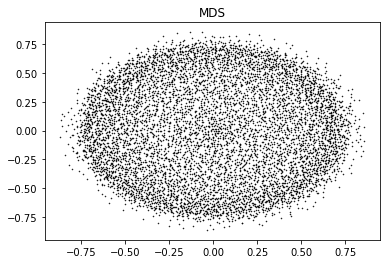

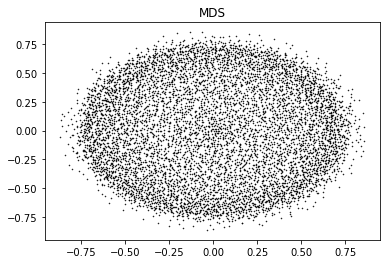

In [6]:
plot_embedding(X_mds,"MDS")

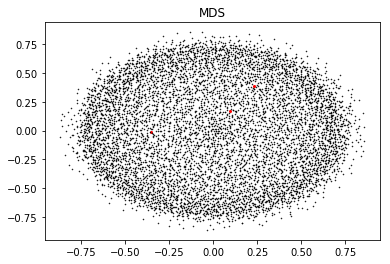

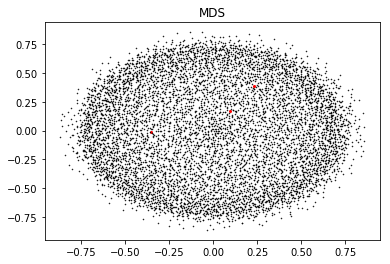

In [7]:
acet_salicyl_a = Chem.MolFromSmiles("O=C(C)Oc1ccccc1C(=O)O")
acet_salicyl_a_idxs = [i for i,m in enumerate(drugbank) if m.HasSubstructMatch(acet_salicyl_a)]
plot_embedding(X_mds,"MDS",highlights=acet_salicyl_a_idxs)

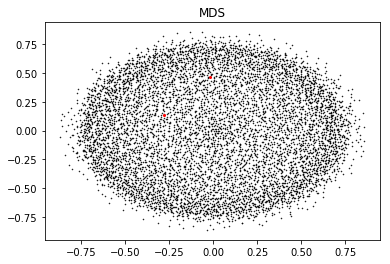

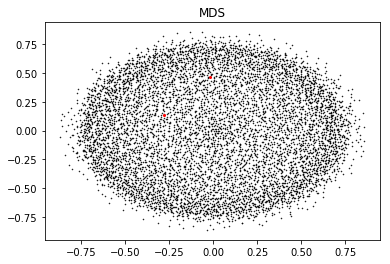

In [10]:
aspirine_like_structs_idxs = [i for i, dist in enumerate(dist_mat[824,]) if dist<0.5] 
plot_embedding(X_mds,"MDS",highlights=aspirine_like_structs_idxs)

In [11]:
# This implementation is also working but why calculate distance if we already have it
# def distance_function(index1, index2, *args, fingerprints=fps):
#     return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],fingerprints[index2])

def full_distance_function(index1, index2, *args, matrix=dist_mat):
    return dist_mat[index1,index2]

picker = MaxMinPicker()
picked = picker.LazyPick(full_distance_function, len(fps), 100, seed=666)
highlighted = tuple(picked)

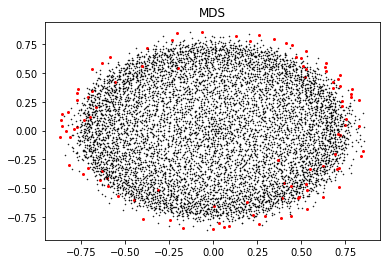

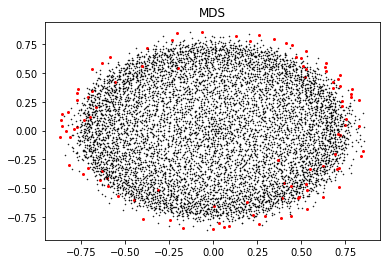

In [12]:
plot_embedding(X_mds,"MDS",highlights=highlighted)

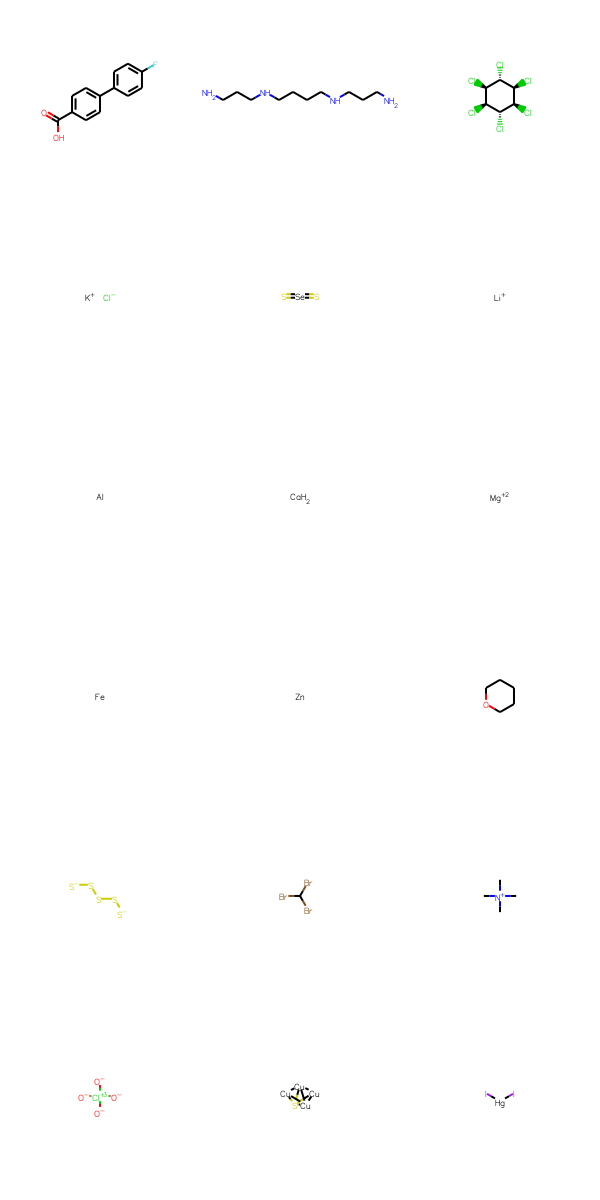

In [13]:
Draw.MolsToGridImage([drugbank[i] for i in picked[:18]])

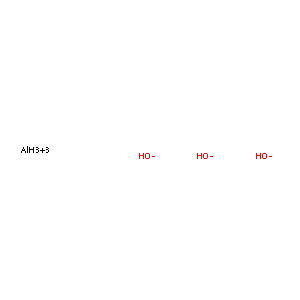

In [14]:
# This one makes all structures so tiny that you can't see them in grid (there could be even more problematic onessimilar)
Draw.MolToImage(drugbank[picked[18]])

In [15]:
hasCarbonPatt = Chem.MolFromSmarts("[#6]")
hasCarbons = [(i, m.HasSubstructMatch(hasCarbonPatt)) for i,m in enumerate(drugbank)]
hasCarbonIdxs = [i for i,has in hasCarbons if has]
hasNotCarbonIdxs = [i for i,has in hasCarbons if not has]
len(hasCarbonIdxs)

7034

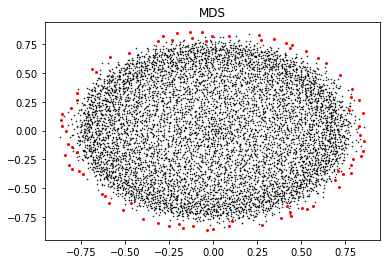

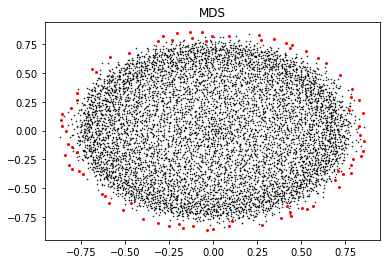

In [16]:
plot_embedding(X_mds,"MDS",highlights=hasNotCarbonIdxs)

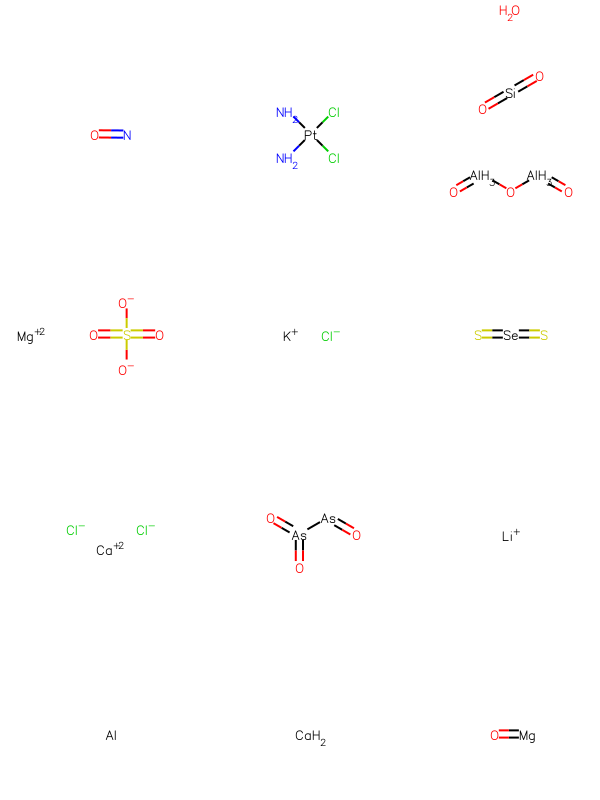

In [17]:
Draw.MolsToGridImage([drugbank[i] for i in hasNotCarbonIdxs[:12]])

In [18]:
onlyOrganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I;!#1]")
onlyOrganics = [(i, m.HasSubstructMatch(hasCarbonPatt) and not m.HasSubstructMatch(onlyOrganicPatt)) for i,m in enumerate(drugbank)]
onlyOrganicIdxs = [i for i,hasPatt in onlyOrganics if hasPatt]
notOnlyOrganicIdxs = [i for i,hasPatt in onlyOrganics if not hasPatt]

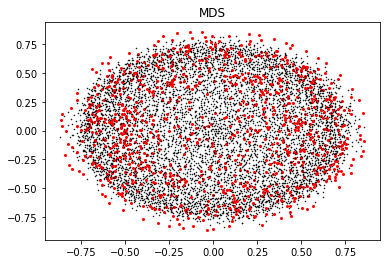

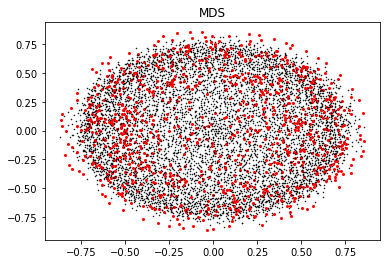

In [19]:
plot_embedding(X_mds,"MDS",highlights=notOnlyOrganicIdxs)

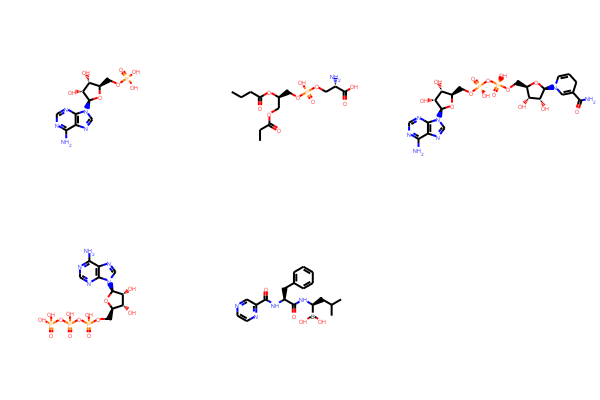

In [20]:
Draw.MolsToGridImage([drugbank[i] for i in notOnlyOrganicIdxs[2:7]])

In [21]:
# These structures are not sanitizable (we can't easily depict it), you should consider usefullness of such structures
print(Chem.MolToSmiles(drugbank[notOnlyOrganicIdxs[1]]))
notSanitizable = drugbank[notOnlyOrganicIdxs[1]]
Chem.SanitizeMol(notSanitizable)

CC1=C2N3=C(C=C4N5=C(C(C)=C6N7[C@@H]8[C@H](CC(N)=O)[C@@]6(C)CCC(=O)NC[C@@H](C)OP(=O)(O)O[C@@H]6[C@@H](CO)O[C@@H]([C@@H]6O)n6cn(c9cc(C)c(C)cc96)~[Co]7~5~3(C#N)~N3=C1[C@@H](CCC(N)=O)[C@](C)(CC(N)=O)[C@]83C)[C@@H](CCC(N)=O)C4(C)C)[C@@H](CCC(N)=O)[C@]2(C)CC(N)=O


rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

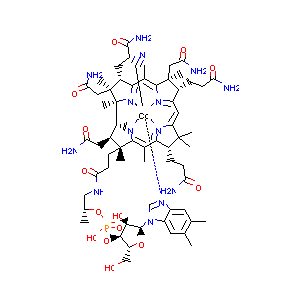

In [22]:
# but after sanitization (even it failed), everything is awesome
Draw.MolToImage(notSanitizable)

In [23]:
remover = SaltRemover(defnData='[!C;!c;!#7;!#8;!#16;!Cl;!F;!Br;!I]')
remover2 = SaltRemover()

In [24]:
print([Chem.MolToSmarts(mol) for mol in remover.salts])
print([Chem.MolToSmarts(mol) for mol in remover2.salts])

['[!C&!c&!#7&!#8&!#16&!Cl&!F&!Br&!I]']
['[Cl,Br,I]', '[#3,#11,#19,#20,#12]', '[O,N]', 'N(=O)(-,:O)O', 'P(=O)(-,:O)(-,:O)O', 'P(-,:F)(-,:F)(-,:F)(-,:F)(-,:F)F', 'S(=O)(=O)(-,:O)O', '[C&H3]S(=O)(=O)-,:O', 'c1cc(-,:[C&H3])ccc1S(=O)(=O)-,:O', '[C&H3]C(=O)O', 'FC(-,:F)(-,:F)C(=O)O', 'OC(=O)C=CC(=O)O', 'OC(=O)C(=O)O', 'OC(=O)C(-,:O)C(-,:O)C(=O)O', 'C1CCCCC1[N&H1]C1CCCCC1']


In [25]:
print(Chem.MolToSmiles(drugbank[notOnlyOrganicIdxs[13]]))
print(Chem.MolToSmiles(remover2(drugbank[notOnlyOrganicIdxs[13]])))

# In this case, we ommit the issue with fragmented structures as we use fingerprint and both fragments are same

O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.[Ca+2]
O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO


In [44]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        # Cyano
        #('[$([N-]C=N)]','N'),
        # Dicyano
        #('[$([N-]C=[N-])]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol

In [27]:
print(Chem.MolToSmiles(remover2(drugbank[notOnlyOrganicIdxs[13]])))
print(Chem.MolToSmiles(NeutraliseCharges(remover2(drugbank[notOnlyOrganicIdxs[13]]))))

O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O=C(O)C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.O=C(O)C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO


In [28]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
_carbonPatt = Chem.MolFromSmarts("[#6]")
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [29]:
supp = Chem.SDMolSupplier("../data/drugbank.sdf")
cleanDrugbank = [sm for sm in (standardize(m) for m in supp if m) if sm]
cleanFps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for i,m in enumerate(cleanDrugbank)]

In [30]:
#Prepare full distance matrix

clean_sparse_mat = distance.pdist(cleanFps,metric="jaccard")
clean_dist_mat = distance.squareform(clean_sparse_mat)

#Calculate new 2D coordinates with MDS

#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
clean_mds = clf.fit_transform(clean_dist_mat)

In [31]:
def clean_distance_function(index1, index2, *args, matrix=clean_dist_mat):
    return matrix[index1,index2]

picker = MaxMinPicker()
clean_picked = picker.LazyPick(clean_distance_function, len(cleanFps), 100, seed=666)
clean_highlighted = tuple(clean_picked)

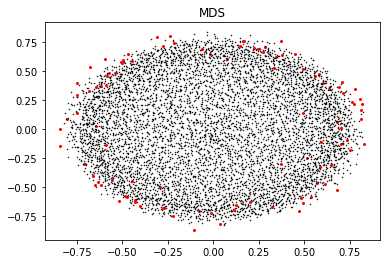

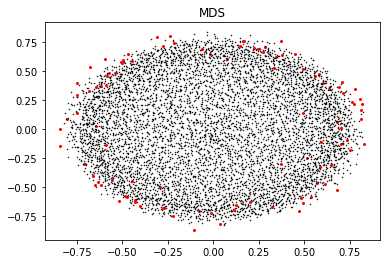

In [32]:
plot_embedding(clean_mds,"MDS",highlights=clean_highlighted)

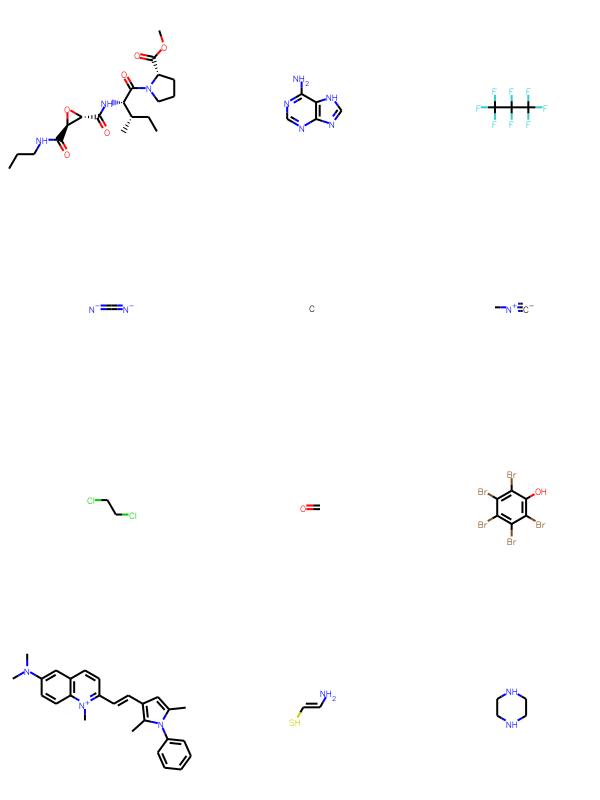

In [33]:
Draw.MolsToGridImage([cleanDrugbank[i] for i in clean_picked[:12]])

[N-]=C=[N-]


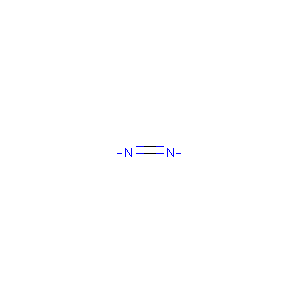

In [34]:
# Calcium Cyanamide CaCN2
print(Chem.MolToSmiles(cleanDrugbank[clean_picked[3]]))
Draw.MolToImage(cleanDrugbank[clean_picked[3]])

In [35]:
cleanDrugbank[clean_picked[3]]

In [42]:
mol = NeutraliseCharges(cleanDrugbank[clean_picked[3]])

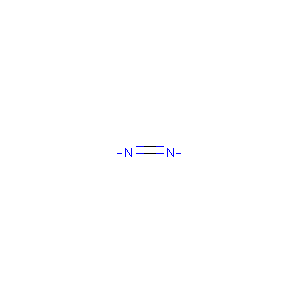

In [43]:
Draw.MolToImage(mol)